# Finding Similar Images with Autoencoders

This is a demo in which we train an autoencoder to compress images down to an 8-byte array and then use that to find similar images. 

(60000, 28, 28, 1)
(10000, 28, 28, 1)


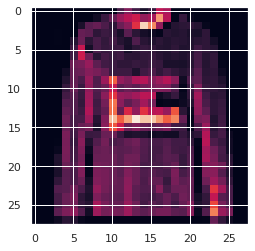

In [8]:
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()


# Load the mnist fashion sample dataset
#(x_train, _), (x_test, _) = mnist.load_data()
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# scale the values down to 0..1 as they are currently 1-byte pixel intensity values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape the data as the neural network expects a 4-Dimensional tensor of (samples, height, width, channels)
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_test.shape)

# Show a sample image (need to reshape back to lose the channel to display)
plt.imshow(x_train[92].reshape(28,28))

In [9]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Sequential, Model

# Create out autoencoder network
autoencoder = Sequential()

# Encoder layers
autoencoder.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2,2), padding='same'))
autoencoder.add(Conv2D(8, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2), padding='same'))
autoencoder.add(Conv2D(4, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2), padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Dense(8, name='code')) # we name this layer so we can refer to it later
autoencoder.add(Dense(4*4*4))
autoencoder.add(Reshape((4, 4, 4))) # reshape it back to original shape

# Decoder layers
autoencoder.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the network
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 4)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)               

In [10]:
# Fit the network. We use 20 epochs here, increase to 100 if you want better results, but will take longer to train 

history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test)
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 278us/sample - loss: 0.3413 - val_loss: 0.3180
Epoch 2/20
60000/60000 [==============================] - 16s 261us/sample - loss: 0.3112 - val_loss: 0.3098
Epoch 3/20
60000/60000 [==============================] - 16s 263us/sample - loss: 0.3066 - val_loss: 0.3076
Epoch 4/20
60000/60000 [==============================] - 16s 264us/sample - loss: 0.3043 - val_loss: 0.3056
Epoch 5/20
60000/60000 [==============================] - 16s 267us/sample - loss: 0.3029 - val_loss: 0.3045
Epoch 6/20
60000/60000 [==============================] - 16s 262us/sample - loss: 0.3020 - val_loss: 0.3036
Epoch 7/20
60000/60000 [==============================] - 16s 261us/sample - loss: 0.3012 - val_loss: 0.3027
Epoch 8/20
60000/60000 [==============================] - 16s 266us/sample - loss: 0.3007 - val_loss: 0.3026
Epoch 9/20
60000/60000 [==============================] - 16s 263us/sample - l

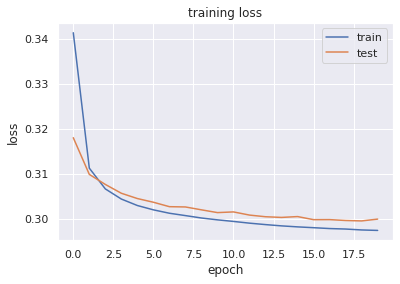

In [11]:
# plot the training losses

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

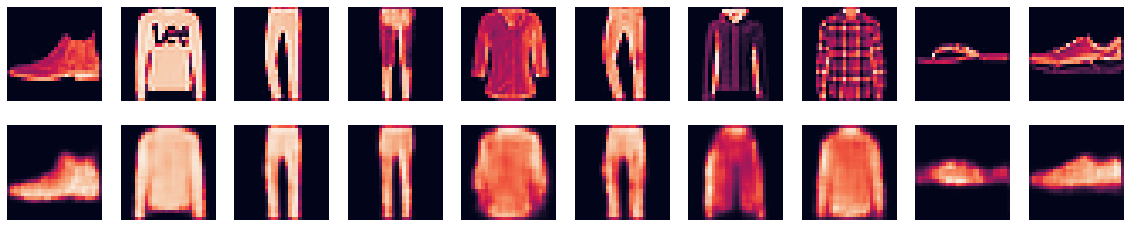

In [12]:
# Run some test images through the full autoencoder. What we get out will be the result of
# compressing then decompressing then again
decoded_imgs = autoencoder.predict(x_test)

# Plot some of the images so we can compare the input and output
n = 10
plt.figure(figsize=(20,4))

for i in range(n):
    # originals
    ax = plt.subplot(2, n, i + 1)
    ax.axis('off')
    plt.imshow(x_test[i].reshape(28,28))
    
    # outputs
    ax = plt.subplot(2, n, i + 1 + n)
    ax.axis('off')
    plt.imshow(decoded_imgs[i].reshape(28,28))
    
plt.show()

In [13]:
# We now want to create just the encoder portion of the autoencoder, so we can
# get the intermediate 8-byte codes out. We know the input later (as ther is only one)
# and can refert the to 'code' layer we named when we created the model

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('code').output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 4)           0     

In [14]:
# Use the encoder part to get the 'codes' for each image
coded_imgs = encoder.predict(x_test)

# This is what an example code looks like, just an 8-byte array
coded_imgs[0]

array([-0.90529007,  1.7705598 , -4.21979   , -2.3572903 ,  1.3291132 ,
       -0.7476535 ,  1.3091083 ,  3.177532  ], dtype=float32)

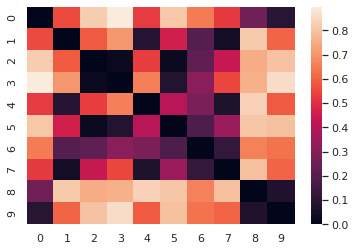

In [15]:
from scipy.spatial.distance import cosine

# Use the 'cosine similarity' as a measure of the similarity between
# each of the first ten image codes
sim = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        rel = cosine(coded_imgs[i], coded_imgs[j])
        sim[i,j] = rel

# Plot a heat map. The major diagonal is all black, as comparing an image to itself results
# in a similarity distance of 0 as it is identical
ax = sns.heatmap(sim)

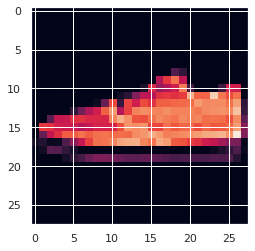

In [19]:
img_idx = 60 # Pick on of the images to use as reference
plt.imshow(x_test[img_idx].reshape(28,28))
src_img_code = coded_imgs[img_idx]


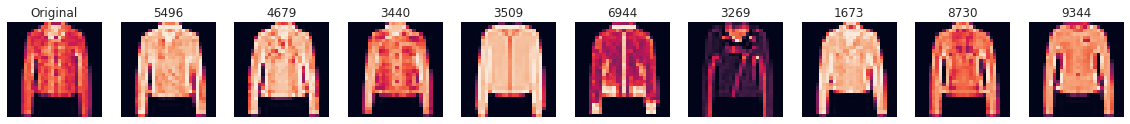

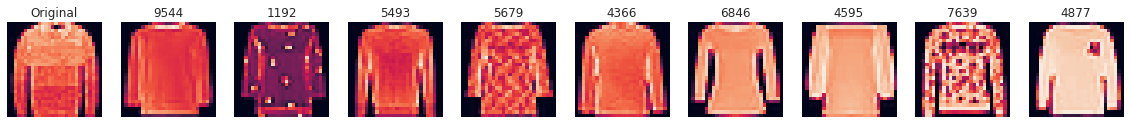

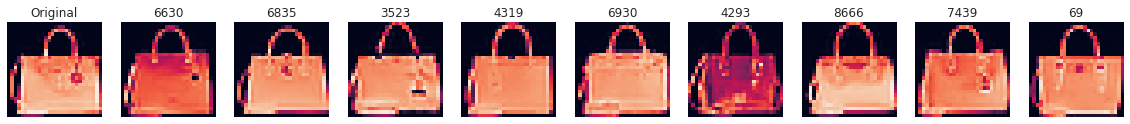

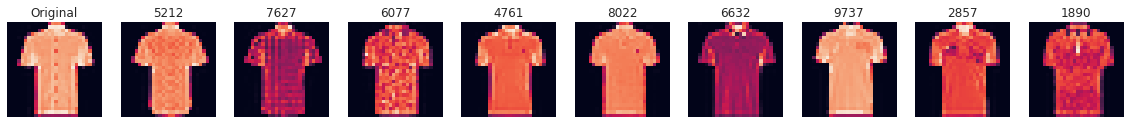

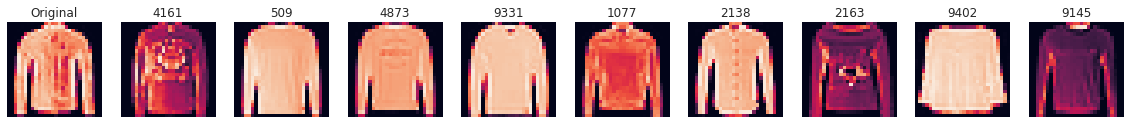

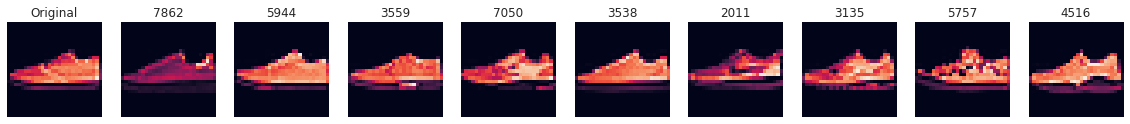

In [29]:
# Function to find similar images to the one supplied by idx
def find_similar_images(idx):
    src_img_code = coded_imgs[idx]

    # calculate the cosine similarity from our reference image to all the other image codes
    similarities = [ (cosine(src_img_code, coded_imgs[i]), i) for i in range(len(coded_imgs)) ]
    similarities.sort()
    similar_idxs = [ i for _,i in similarities ]

    # plot top 10 matches
    plt.figure(figsize=(20,4))
    for i, idx in enumerate(similar_idxs[:n]):
        ax = plt.subplot(2, n, i + 1)
        ax.axis('off')
        if i == 0:
          ax.set_title("Original")
        else:
          ax.set_title(idx)
        plt.imshow(x_test[idx].reshape(28,28))

# Run for a sample of our images
for i in [10, 20, 30, 40, 50, 60]:
    find_similar_images(i)
    plt.show()